Implementation of EEG classification using GRU RNN + Convolution + Inception modules + Densely connected layers
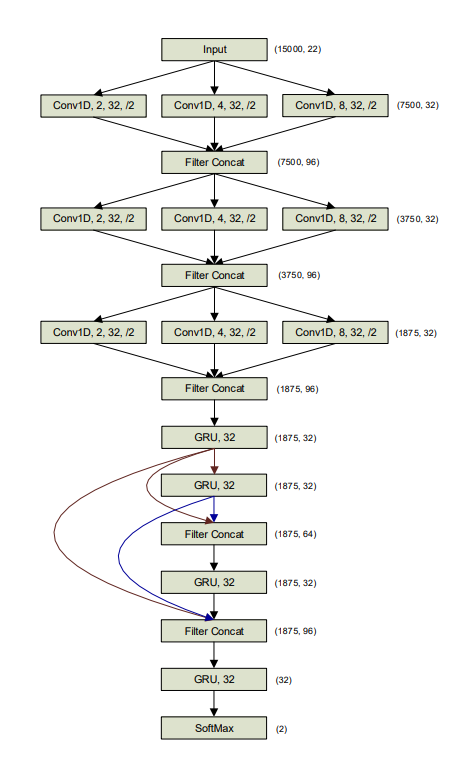

In [22]:
pip install torch torchvision torchaudio

^C
Note: you may need to restart the kernel to use updated packages.


In [23]:
import torch.nn as nn
import torch
input=torch.randn(3,22,15000) #Random tensor with 3 batch_size, 22 channel and 15000 timepoints
input.shape

torch.Size([3, 22, 15000])

In [24]:
#Convolution layer in pytorch
nn.Conv1d(in_channels=22,out_channels=32,kernel_size=2,stride=2,padding=0)

Conv1d(22, 32, kernel_size=(2,), stride=(2,))

In [25]:
#Building the block architecture using OOP paradigm
class Block(nn.Module):
    def __init__(self,inplace):
        super().__init__()
        self.conv1=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=2,stride=2,padding=0)
        self.conv2=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=4,stride=2,padding=1)
        self.conv3=nn.Conv1d(in_channels=inplace,out_channels=32,kernel_size=8,stride=2,padding=3)
        self.relu=nn.ReLU()

    def forward(self,x):
        x1=self.relu(self.conv1(x))
        x2=self.relu(self.conv2(x))
        x3=self.relu(self.conv3(x))
        x=torch.cat([x1,x2,x3],dim=1)
        return x

In [5]:
#Implementing the first inception module
block=Block(22) #Input is channel number (eeg channels)
out1=block(input)
out1.shape

torch.Size([3, 96, 7500])

In [6]:
#Implementing the second inception module
block=Block(96) #Input is channel number (sum of the feature maps from the previous convolution layer)
out2=block(out1)
out2.shape

torch.Size([3, 96, 3750])

In [7]:
#Implementing the third inception module
block=Block(96) #Input is channel number (sum of the feature maps from the previous convolution layer)
out3=block(out2)
out3.shape

torch.Size([3, 96, 1875])

In [10]:
#Implementation GRU with pytorch, to return output and hidden layer
gru=nn.GRU(input_size=96,hidden_size=32,batch_first=True) #Initializing the GRU with (N,L,Hin) format
x=out3.permute(0,2,1) #Rearranging the input shape acording to what GRU layer expects
print(x.shape)
output,hn=gru(x) #GRU gives output and the hidden layer
print(output.shape,hn.shape)

torch.Size([3, 1875, 96])
torch.Size([3, 1875, 32]) torch.Size([1, 3, 32])


In [12]:
#Implementing the GRU Layers for C-RNN
gru1=nn.GRU(input_size=96,hidden_size=32,batch_first=True)
gru2=nn.GRU(input_size=32,hidden_size=32,batch_first=True)
gru_out1,_=gru1(x) #Input is the permutated data from 3rd inception module
gru_out2,_=gru2(gru_out1) #Input is output of the previous GRU layer
gru_out=torch.cat([gru_out1,gru_out2],dim=2) #Concatenate the output of gru layer 1 & 2 at the 2nd dim
gru_out.shape

torch.Size([3, 1875, 64])

In [14]:
gru3=nn.GRU(input_size=64,hidden_size=32,batch_first=True)
gru_out3,_=gru3(gru_out) #Input is concatenated output of GRU layer 1 & 2
gru_out3.shape

torch.Size([3, 1875, 32])

In [15]:
#Concatenate the output of GRU layer 1, 2 & 3 at the 2nd DIM (channels)
gru_out=torch.cat([gru_out1,gru_out2,gru_out3], dim=2)
gru_out.shape

torch.Size([3, 1875, 96])

In [19]:
#To convert sequence length from 1875 to 1
linear=nn.Linear(1875,1)
linear_out=linear(gru_out.permute(0,2,1)) #Rearrange the gru_out shape for channel to be in the middle
linear_out.shape 

torch.Size([3, 96, 1])

In [21]:
gru4=nn.GRU(input_size=96,hidden_size=32,batch_first=True)
gru_out4,_=gru4(linear_out.permute(0,2,1)) #Input is the concatenated output of GRU layer 1, 2 & 3, with sequence length 1
gru_out4.shape

torch.Size([3, 1, 32])

In [60]:
#Creating an archictecture from all the modules (ChronoNet)
class ChronoNet(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.block1=Block(channel)
        self.block2=Block(96)
        self.block3=Block(96)
        self.gru1=nn.GRU(input_size=96,hidden_size=32,batch_first=True)
        self.gru2=nn.GRU(input_size=32,hidden_size=32,batch_first=True)
        self.gru3=nn.GRU(input_size=64,hidden_size=32,batch_first=True)
        self.gru4=nn.GRU(input_size=96,hidden_size=32,batch_first=True)
        self.gru_linear=nn.Linear(64,1)
        self.flatten=nn.Flatten()
        self.fcl=nn.Linear(32,1)
        self.relu=nn.ReLU()
        
    def forward(self,x):
        x=self.block1(x)
        x=self.block2(x)
        x=self.block3(x) #Note that x changes sequentially, feeding the next block
        x=x.permute (0,2,1) #Rearranging the input shape acording to what GRU layer expects
        gru_out1,_=self.gru1(x)
        gru_out2,_=self.gru2(gru_out1)
        gru_out=torch.cat([gru_out1,gru_out2],dim=2)
        gru_out3,_=self.gru3(gru_out)
        gru_out=torch.cat([gru_out1,gru_out2,gru_out3],dim=2)

        #print('gru_out',gru_out.shape) to know the final shape for the linear layer
        linear_out=self.relu(self.gru_linear(gru_out.permute(0,2,1)))
        gru_out4,_=self.gru4(linear_out.permute(0,2,1))
        x=self.flatten(gru_out4)
        x=self.fcl(x)
        return x

In [28]:
model=ChronoNet()
out=model(input)
out.shape

torch.Size([3, 1])

Implementation of a classification model for IDD and TDC using the dataset described below.
The dataset is a collection of EEG recordings of seven participants with Intellectual and Developmental Disorder (IDD) and seven Typically Developing Controls (TDC). The data is recorded while the participants observe a resting state and a soothing music stimuli. The data was collected using a high-resolution multi-channel dry-electrode system from EMOTIV called EPOC+. This is a 14-channel device with two reference channels and a sampling frequency of 128 Hz. 

In [29]:
IDD='C:/Users/mikky/Desktop/EEG_Projects/EEG dataset of IID/Data/CleanData/CleanData_IDD/Rest'
TDC='C:/Users/mikky/Desktop/EEG_Projects/EEG dataset of IID/Data/CleanData/CleanData_TDC/Rest'

In [30]:
#Reading the data in the IDD folder using loadmat func
from glob import glob
import scipy.io
for idd in glob(IDD+'/*.mat'):
    data=scipy.io.loadmat(idd)
    break

In [31]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'clean_data'])

In [33]:
data=data['clean_data']
data.shape

(14, 15360)

In [34]:
!pip install  mne

In [35]:
import mne
n_channels = 14
sampling_freq = 128  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
 chs: 14 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>


In [36]:
ch_names = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
ch_types = ["eeg"] * 14
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,17 points
Good channels,14 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,128.00 Hz
Highpass,0.00 Hz
Lowpass,64.00 Hz


In [38]:
data=mne.io.RawArray(data, info)

Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.


In [39]:
epochs=mne.make_fixed_length_epochs(data,duration=4,overlap=0)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


In [40]:
epochs.get_data().shape

Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped


(30, 14, 512)

In [42]:
#Converting the matlab file to mne
def convertmat2mne(data):
    ch_names = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
    ch_types = ["eeg"] * 14
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    info.set_montage("standard_1020")
    data=mne.io.RawArray(data, info)
    data.set_eeg_reference()
    data.filter(l_freq=1,h_freq=30)
    epochs=mne.make_fixed_length_epochs(data,duration=4,overlap=0)
    return epochs.get_data()


In [46]:
#Importing and converting IDD files to mne
idd_subject=[]
for idd in glob(IDD+'/*.mat'):
    data=scipy.io.loadmat(idd)['clean_data']
    data=convertmat2mne(data)
    idd_subject.append(data)

Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 s)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs drop

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


- Filter length: 423 samples (3.305 s)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 s)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs drop

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished



Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


In [44]:
#Importing and converting TDC files to mne
tdc_subject=[]
for tdc in glob(TDC+'/*.mat'):
    data=scipy.io.loadmat(tdc)['clean_data']
    data=convertmat2mne(data)
    tdc_subject.append(data)

Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 s)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs drop

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 s)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 s)

Not setting metad

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 s)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished


In [47]:
len(idd_subject),len(tdc_subject)

(7, 7)

In [50]:
#Creating labels for the files
control_epochs_labels=[len(i)*[0] for i in tdc_subject] #label all epochs in each control file zero
patient_epochs_labels=[len(i)*[1] for i in idd_subject] #label all epochs in each patient file one
len(control_epochs_labels), len(patient_epochs_labels)

(7, 7)

In [52]:
#We need to combine both data and the labels, to form a dataset for the NN
data_list=tdc_subject+idd_subject #one dataset from TDC and IDD data
label_list=control_epochs_labels+patient_epochs_labels #one dataset from TDC and IDD labels
len(data_list), len(label_list)

(14, 14)

In [53]:
#Grouping the data - Avoid grouping based on epochs or the machine learning model would have seen the unseen data, group based on participants
groups=[[i]*len(j) for i,j in enumerate(data_list)]
len(groups)

14

In [54]:
#Create 5 Fold cross-validation loop and train the model for each loop
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()

In [56]:
import numpy as np
#Reshape data because CNN expects data in a particular shape. First check shape by converting list to array
epochs_array=np.vstack(data_list)
epochs_labels=np.hstack(label_list)
groups_array=np.hstack(groups)
epochs_array=np.moveaxis(epochs_array,1,2)

epochs_array.shape, epochs_labels.shape, groups_array.shape

((420, 512, 14), (420,), (420,))

In [57]:
#Splitting the train and val data for each group
accuracy=[]
for train_index,val_index in gkf.split(epochs_array,epochs_labels,groups=groups_array):
    train_features,train_labels=epochs_array[train_index],epochs_labels[train_index]
    val_features,val_labels=epochs_array[val_index],epochs_labels[val_index]
    scaler=StandardScaler()
    train_features=scaler.fit_transform(train_features.reshape(-1,train_features.shape[-1])).reshape(train_features.shape)
    val_features=scaler.fit_transform(val_features.reshape(-1,val_features.shape[-1])).reshape(val_features.shape)
    break

In [58]:
train_features.shape, val_features.shape

((330, 512, 14), (90, 512, 14))